<font color='blue'> **02 - Two aquifers are separated by a confining bed** </font> 
<font color='red'> **Node Property Flow (NPF)** </font>
<font color='blue'> **Rewetting example** </font>  

In [1]:
import os ;  from pathlib import Path; import flopy ; import matplotlib.pyplot as plt; import pandas as pd ; import numpy as np     
from flopy.plot.styles import styles ; from modflow_devtools.misc import get_env, timed
write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)
_R = Path("_R")   ; _R.mkdir(exist_ok=True); TA = Path("_R/02_ex-gwf-bcf2ss"); TA.mkdir(exist_ok=True) ; REF0=Path('E:/15_REPOS/02_Beta-Me/data/MF6/_aux')

REF1 = os.path.join('E:/15_REPOS/00_BETAMI/bin/data_modflow6-examples/ex-gwf-bcf2ss', "wetdry01.txt")       
wetdry_layer0 = np.loadtxt(REF1)   ; np.savetxt(TA/"a_wetdry_layer0.csv", wetdry_layer0, delimiter = ",")    

In [2]:
parameters = {"ex-gwf-bcf2ss-p01": {"rewet":  True,"wetfct":  1.0,"iwetit": 1   ,"ihdwet": 0   ,"linear_acceleration": "cg"      ,"newton": None},
              "ex-gwf-bcf2ss-p02": {"rewet": False,"wetfct": None,"iwetit": None,"ihdwet": None,"linear_acceleration": "bicgstab","newton": "NEWTON"}}
with open(TA/'_a_parameters.txt', 'w') as f:             
    print(parameters, file=f)    
nlay  = 2  ;nrow = 10    ;ncol = 15 ;delr = 500 ;delc = 500   ; top = 150 ;botm_str = "50.0,-50."  ; icelltype_str = "1, 0"   ; k33 = 0.1  ;strt = 0 ;recharge = 0.004
nouter=500 ;ninner = 100 ;hclose=0.000001     ;rclose=0.001   ; relax = 0.97 ;  k11_str = "10, 5"                             ; nper = 2 ; tdis_ds = ((1.0, 1.0, 1),(1.0, 1.0, 1),)

botm      = [float(value) for value in botm_str.split(",")]            ; length_units = "feet" ; time_units = "days"              
icelltype = [int(value) for value in icelltype_str.split(",")]       ; k11 = [float(value) for value in k11_str.split(",")]
wel_spd   = {1: [[1, 2, 3, -35000.0],[1, 7, 3, -35000.0],]}          ; riv_spd = {0: [[1, i, 14, 0.0, 10000.0, -5] for i in range(nrow)]}
print('icelltype',icelltype, 'k11', k11)

icelltype [1, 0] k11 [10.0, 5.0]


wel_spd (2, 1)
river (10, 6)
sufaces [[150.0], [50.0], [-50.0]]


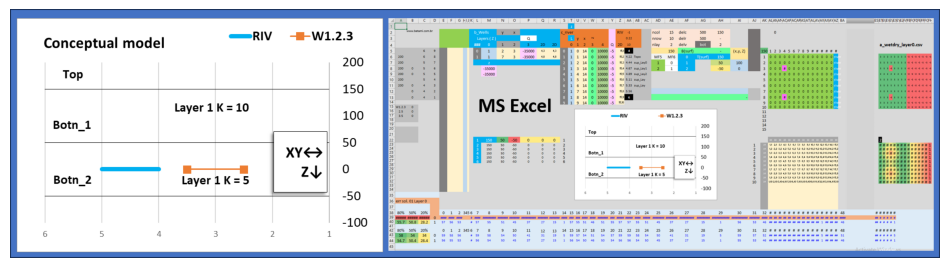

In [4]:
row = wel_spd      ; sa  = pd.DataFrame(row)  ; sa.to_csv (TA / "b_wel_spd.csv")      ; print('wel_spd',sa.shape)
row = riv_spd  [0] ; sa  = pd.DataFrame(row)  ; sa.to_csv (TA / "c_river.csv")        ; print('river',sa.shape)
top=[top]          ; sa1 = pd.DataFrame(top)  ; sa2=pd.DataFrame(botm) ; fr=[sa1,sa2] ;rs=pd.concat(fr) ; rs=rs.values.tolist()         ; print('sufaces',rs)
image = plt.imread(REF0/'02_BCF2SS.png'); fig, ax = plt.subplots(figsize=(12, 5)) ; ax.imshow(image) ; ax.axis('off') ; plt.show() 

In [5]:
sim_name = "AB"  
def build_models(name, rewet, wetfct, iwetit, ihdwet, linear_acceleration, newton):
    rewet = []
    if rewet:  rewet_record = ["wetfct", wetfct, "iwetit", iwetit, "ihdwet", ihdwet]       ; wetdry = [wetdry_layer0, 0]
    else:      rewet_record = None  ; wetdry = None
    head_filerecord = f"{sim_name}.hds" ; budget_filerecord = f"{sim_name}.cbc"

    TB = os.path.join(TA/name)  
    sim    = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=TB)
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)           ; RC = f"{rclose} strict"
    flopy.mf6.ModflowIms  (sim,linear_acceleration='bicgstab',outer_maximum=nouter, inner_maximum=ninner,outer_dvclose=hclose,inner_dvclose=hclose,rcloserecord=RC,relaxation_factor=relax)
    gwf = flopy.mf6.ModflowGwf (sim, modelname=sim_name, save_flows=True, newtonoptions=newton)
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf  (gwf,rewet_record=rewet_record,      wetdry=wetdry,icelltype=icelltype,    k=k11,k33=k33,save_specific_discharge=True)
    flopy.mf6.ModflowGwfic   (gwf, strt=strt)                                       ; flopy.mf6.ModflowGwfriv  (gwf, stress_period_data=riv_spd)
    flopy.mf6.ModflowGwfwel  (gwf, stress_period_data=wel_spd)                      ; flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge)
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    return sim

def write_models(sim, silent=True):     sim.write_simulation(silent=silent)
def run_models(sim, silent=True):       success, buff = sim.run_simulation(silent=silent)  ;     assert success, buff
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx] ; params = parameters[key].copy() ; sim = build_models(key, **params)
    if write: write_models(sim, silent=silent)
    if run:   run_models(sim, silent=silent)
scenario(0) ; scenario(1)

In [6]:
sim = flopy.mf6.MFSimulation.load (sim_ws = os.path.join(TA/'ex-gwf-bcf2ss-p01') , verbosity_level=0)
gwf=sim.get_model(sim_name) ; hobj=gwf.output.head()      ; head=hobj.get_data() ; cobj=gwf.output.budget()  
print('heads=', head.shape); sv = head.reshape(head.shape[0],-1)     ; th=pd.DataFrame(sv)  ; th.to_csv (TA / 'd1_H_3D.csv' )  ; th

heads= (2, 10, 15)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,...,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30,-1.000000e+30
1,5.717468e+01,5.566528e+01,5.322608e+01,5.146133e+01,5.321702e+01,5.563475e+01,5.708128e+01,5.689356e+01,5.483090e+01,5.081017e+01,...,5.563475e+01,5.708128e+01,5.689356e+01,5.483090e+01,5.081017e+01,4.480334e+01,3.680109e+01,2.680035e+01,1.480011e+01,8.000048e-01


In [7]:
sim = flopy.mf6.MFSimulation.load (sim_ws = os.path.join(TA/'ex-gwf-bcf2ss-p02') , verbosity_level=0)

gwf=sim.get_model(sim_name)  ; hobj=gwf.output.head()               ; head=hobj.get_data() ; cobj=gwf.output.budget()  
print('heads=', head.shape)  ; sv = head.reshape(head.shape[0],-1)  ; th=pd.DataFrame(sv)  ; th.to_csv (TA / 'd2_H_3D.csv' )  ; th

heads= (2, 10, 15)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,59.376900,58.220710,56.336023,54.930913,56.326277,58.192593,59.299633,59.149178,57.564570,54.461763,...,58.192593,59.299633,59.149178,57.564570,54.461763,49.660526,40.801198,30.800389,18.800117,4.800005
1,55.954511,54.669905,52.556422,50.973781,52.548038,54.642869,55.873484,55.710019,53.935238,50.382697,...,54.642869,55.873484,55.710019,53.935238,50.382697,44.803655,36.801198,26.800389,14.800117,0.800005


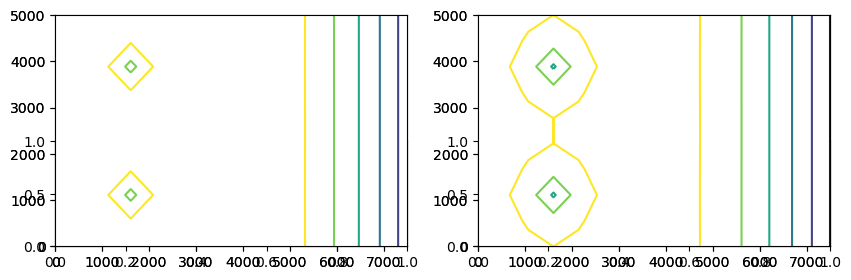

In [8]:
def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        Layer = 0; ax1 = fig.add_subplot(121) ; ax1.contour( head [Layer,:,:]   ,levels=np.arange(Layer, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
        Layer = 1; ax2 = fig.add_subplot(122) ; ax2.contour( head [Layer,:,:]   ,levels=np.arange(Layer, np.percentile(sv[0],95),10)   , extent=gwf.modelgrid.extent)
fig = plt.figure(figsize=(10, 3))    ; ax1 = plt.subplot2grid((2, 2), (1, 0))   ; ax2 = plt.subplot2grid((2, 2), (1, 1))  ; annotate_axes(fig) ; plt.show()

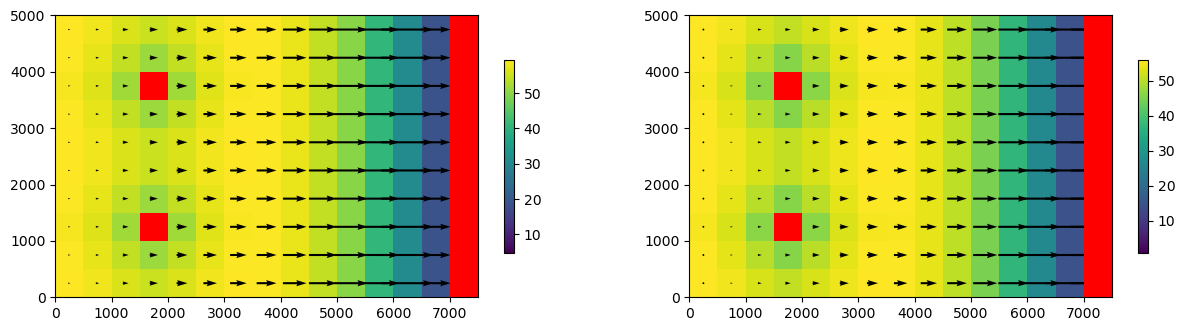

In [9]:
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)
fig = plt.figure(figsize=(15, 5))          
ax = fig.add_subplot(121) ; L = 0           ; mm = flopy.plot.PlotMapView(model=gwf, layer=L, extent=gwf.modelgrid.extent)  ; cbv = mm.plot_array(head) ; q = mm.plot_vector(qx, qy)  
cb = plt.colorbar(cbv, ax=mm.ax, shrink=.5) ; mm.plot_bc(ftype="RIV", color="red", plotAll=True); mm.plot_bc(ftype="WEL", kper=1, plotAll=True)
ax = fig.add_subplot(122) ; L = 1           ; mm = flopy.plot.PlotMapView(model=gwf, layer=L, extent=gwf.modelgrid.extent)  ; cbv = mm.plot_array(head) ; q = mm.plot_vector(qx, qy)  
cb = plt.colorbar(cbv, ax=mm.ax, shrink=.5) ; mm.plot_bc(ftype="RIV", color="red", plotAll=True); mm.plot_bc(ftype="WEL", kper=1, plotAll=True)